In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('online_retail_II.csv')

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  str    
 1   StockCode    1067371 non-null  str    
 2   Description  1062989 non-null  str    
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  str    
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 65.1 MB


In [6]:
df = df.dropna(subset=['Customer ID'])


In [7]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]


In [8]:
df = df[df['Quantity'] > 0]


In [9]:
df['TotalAmount'] = df['Quantity'] * df['Price']


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [11]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [12]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [13]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm[['R_score','F_score','M_score']] = rfm[['R_score','F_score','M_score']].astype(int)


In [14]:
rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)


In [15]:
def segment_customer(row):
    if row['R_score'] == 4 and row['F_score'] == 4:
        return 'Champions'
    elif row['F_score'] >= 3 and row['R_score'] >= 3:
        return 'Loyal Customers'
    elif row['R_score'] >= 3 and row['F_score'] <= 2:
        return 'Potential Loyalists'
    elif row['R_score'] == 4:
        return 'New Customers'
    elif row['R_score'] <= 2 and row['F_score'] >= 3:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,4,4,244,At Risk
12347.0,2,8,5633.32,4,4,4,444,Champions
12348.0,75,5,2019.40,3,3,3,333,Loyal Customers
12349.0,19,4,4428.69,4,3,4,434,Loyal Customers
12350.0,310,1,334.40,2,1,1,211,Hibernating


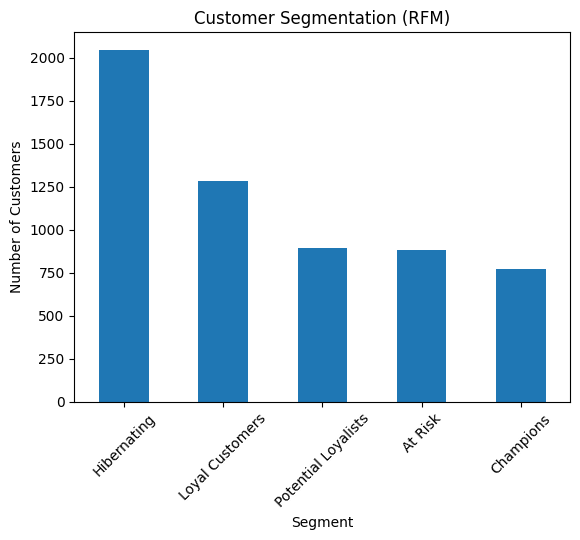

In [16]:
segment_counts = rfm['Segment'].value_counts()

plt.figure()
segment_counts.plot(kind='bar')
plt.title('Customer Segmentation (RFM)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [18]:
rfm.to_csv('rfm_segments.csv', index=True)
